In [2]:
# Загружаем датасет рукописных английских букв emnist
# Каждая буква представлена в формате картинки 28х28 пикселей
import kagglehub

path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\fdsaf\.cache\kagglehub\datasets\crawford\emnist\versions\3


In [3]:
# Необходимо взять emnist-letters-test.csv и emnist-letters-train.csv
# Каждая строка в таблице - отдельная картинка
# 785 (28 x 28) столбцов, каждый столбец = величина пикселя 
# Первый столбец — это метка класса (какая это буква). Подробнее в mappings.txt
import pandas as pd # для обработки данных
testing_letter = pd.read_csv(path + '/emnist-letters-test.csv')
training_letter = pd.read_csv(path + '/emnist-letters-train.csv')

print(training_letter.shape) # 88799 = количество элементов для обучения
print(testing_letter.shape) # 14799 = кол-во элементов для тестирования

(88799, 785)
(14799, 785)


(88799,)
(88799, 784)


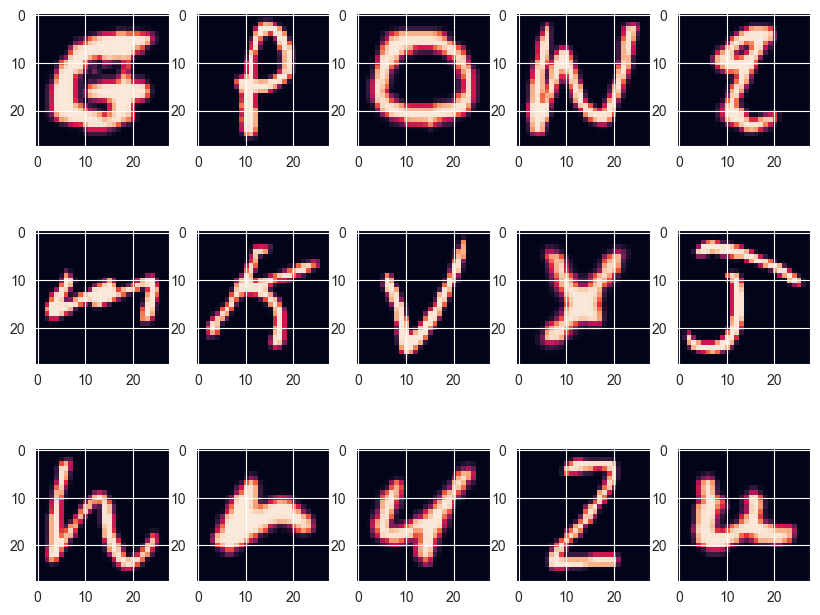

In [4]:
import numpy as np # для линейной алгебры
# training_letter
y1 = np.array(training_letter.iloc[:,0].values) # Берём первый столбец всех строк (метка класса)
x1 = np.array(training_letter.iloc[:,1:].values) # Все строки, все столбцы кроме первого столбца
# testing_letter
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape) # метки для обучающей выборки
print(x1.shape) # признаки обучающей выборки


# Проверка картинок
import matplotlib.pyplot as plt # для создания графиков
fig,axes = plt.subplots(3,5,figsize=(10,8)) # создаёт сетку 3х5 из графиков, каждая клетка размером 10х8
for i,ax in enumerate(axes.flat): # индекс, объект оси
    ax.imshow(x1[i].reshape([28,28]).T) # отображает изображение, нужно транспонировать

In [5]:
# Перед тем, как подавать в данные в модель, мы нормализуем и изменим предоставленные нам данные. Это уменьшит сложность моделей и сделает модель эффективно работать, так как для обработки будут менее сложные числа.

# Приводим данные к диапазону [0,1]
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0] # кол-во изображений в обучающей выборке
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)
# кол-во изображений, высота, ширина, 1 = кол-во каналов (1 т.к. чёрно белое)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

In [6]:
import tensorflow as tf

# Количество классов (26 букв английского алфавита + спец символы)
number_of_classes = 37

# Преобразует метки классов в one-hot encoding.
# Например Если y1[i] = 2, то one-hot encoding будет [0, 0, 1, 0, ..., 0] 
# (длина вектора равна number_of_classes).
y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

In [7]:
# Функция из библиотеки scikit-learn, которая разделяет данные на обучающую и тестовую выборки.
from sklearn.model_selection import train_test_split

# Делим данные на две части: обучающая выборка (80% данных), валидационная выборка (20% данных). 
# Фиксируем случайное разбиение для воспроизводимости результатов (random_state = 42)
train_x,test_x,train_y,test_y = train_test_split(train_images,y1,test_size=0.2,random_state = 42)

# Создание сверточной НС. Эта модель является FFNN, так как она соответствует определению сети прямого распространения.
# 1. Сверточный слой (Conv2D): 32 фильтра размером 3x3. Размер входных данных (28x28 пикселей, 1 канал)
# 2. Слой подвыборки (MaxPooling2D): Уменьшает размерность данных, выбирая макс значение в окне 2x2
# 3. Слой выравнивания (Flatten): Преобразует двумерные данные в одномерный вектор.
# 4. Полносвязные слои (Dense): Слой с 512 и 128 нейронами и функцией активации ReLU.
# 5. Выходной слой (Dense): Слой с количеством нейронов, равным числу классов (37), и функцией активации softmax
def configure_model(activation='relu', hidden_units=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.Dense(hidden_units, activation=activation),
        tf.keras.layers.Dense(number_of_classes, activation='softmax')
    ])
    return model

model = configure_model()

C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
def compile_model(model, epochs=10):
    # Модель настраивается для обучения.
    # optimizer='rmsprop': Используется оптимизатор RMSprop для обновления весов модели.
    # loss='categorical_crossentropy': Функция потерь для многоклассовой классификации
    # metrics=['accuracy']: Метрика, которая будет отслеживаться во время обучения (точность).
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    # EarlyStopping, ReduceLROnPlateau, ModelCheckpoint:
    # Это callback-функции, которые используются для улучшения процесса обучения модели.
    # EarlyStopping: Останавливает обучение, если метрика (например, точность) перестает улучшаться.
    # ReduceLROnPlateau: Уменьшает скорость обучения, если метрика перестает улучшаться.
    # ModelCheckpoint: Сохраняет лучшую версию модели во время обучения.

    MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
    ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
    RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

    # объект, который содержит информацию о процессе обучения (например, значения потерь и точности на каждой эпохе).
    history = model.fit(train_x,train_y,epochs=epochs,validation_data=(test_x,test_y),callbacks=[MCP,ES,RLP])
    return history
history = compile_model(model)

Epoch 1/10
2204/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1459 - loss: 2.9169
Epoch 1: val_accuracy improved from -inf to 0.28823, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1462 - loss: 2.9144 - val_accuracy: 0.2882 - val_loss: 2.2064 - learning_rate: 0.0010
Epoch 2/10
2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3083 - loss: 2.1086
Epoch 2: val_accuracy improved from 0.28823 to 0.37562, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3083 - loss: 2.1085 - val_accuracy: 0.3756 - val_loss: 1.9617 - learning_rate: 0.0010
Epoch 3/10
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3894 - loss: 1.8624
Epoch 3: val_accuracy improved from 0.37562 to 0.43153, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3894 - loss: 1.8624 - val_accuracy: 0.4315 - val_loss: 1.8226 - learning_rate: 0.0010
Epoch 4/10
2216/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4471 - loss: 1.7241
Epoch 4: val_accuracy improved from 0.43153 to 0.45377, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4472 - loss: 1.7240 - val_accuracy: 0.4538 - val_loss: 1.7825 - learning_rate: 0.0010
Epoch 5/10
2211/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4880 - loss: 1.6201
Epoch 5: val_accuracy improved from 0.45377 to 0.49195, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4880 - loss: 1.6201 - val_accuracy: 0.4919 - val_loss: 1.6936 - learning_rate: 0.0010
Epoch 6/10
2214/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5082 - loss: 1.5535
Epoch 6: val_accuracy improved from 0.49195 to 0.50878, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5082 - loss: 1.5535 - val_accuracy: 0.5088 - val_loss: 1.7043 - learning_rate: 0.0010
Epoch 7/10
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5263 - loss: 1.4988
Epoch 7: val_accuracy did not improve from 0.50878
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5263 - loss: 1.4988 - val_accuracy: 0.5016 - val_loss: 1.6918 - learning_rate: 0.0010
Epoch 8/10
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5436 - loss: 1.4515
Epoch 8: val_accuracy improved from 0.50878 to 0.51593, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5436 - loss: 1.4515 - val_accuracy: 0.5159 - val_loss: 1.6969 - learning_rate: 0.0010
Epoch 9/10
2214/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5591 - loss: 1.4140
Epoch 9: val_accuracy improved from 0.51593 to 0.54240, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5591 - loss: 1.4141 - val_accuracy: 0.5424 - val_loss: 1.6659 - learning_rate: 0.0010
Epoch 10/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5815 - loss: 1.3719
Epoch 10: val_accuracy improved from 0.54240 to 0.56239, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5815 - loss: 1.3719 - val_accuracy: 0.5624 - val_loss: 1.6652 - learning_rate: 0.0010


In [8]:
# для создания статистических графиков.
import seaborn as sns

# Получаем количество эпох, на которых обучалась модель
# history.history['accuracy'] содержит значения точности на обучающих данных для каждой эпохи
q = len(history.history['accuracy'])

# Устанавливаем размер графика (10x10 дюймов)
plt.figsize=(10,10)

# Строим график точности на обучающих данных (accuracy)
# x = range(1, 1+q): ось X — это номера эпох (начиная с 1)
# y = history.history['accuracy']: ось Y — значения точности на обучающих данных
# label='Accuracy': подпись для графика
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')

NameError: name 'history' is not defined

C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2206/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1468 - loss: 2.8759
Epoch 1: val_accuracy improved from -inf to 0.35766, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1473 - loss: 2.8734 - val_accuracy: 0.3577 - val_loss: 2.0377 - learning_rate: 0.0010
2202/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1507 - loss: 2.9154
Epoch 1: val_accuracy improved from -inf to 0.29938, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1512 - loss: 2.9124 - val_accuracy: 0.2994 - val_loss: 2.0978 - learning_rate: 0.0010
2210/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5018 - loss: 1.8130
Epoch 1: val_accuracy improved from -inf to 0.79341, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5026 - loss: 1.8099 - val_accuracy: 0.7934 - val_loss: 0.7072 - learning_rate: 0.0010
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5994 - loss: 1.4094
Epoch 1: val_accuracy improved from -inf to 0.83086, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5996 - loss: 1.4087 - val_accuracy: 0.8309 - val_loss: 0.5632 - learning_rate: 0.0010
2210/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6629 - loss: 1.1846
Epoch 1: val_accuracy improved from -inf to 0.85062, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6635 - loss: 1.1825 - val_accuracy: 0.8506 - val_loss: 0.4899 - learning_rate: 0.0010
2211/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6766 - loss: 1.1127
Epoch 1: val_accuracy improved from -inf to 0.86340, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6771 - loss: 1.1110 - val_accuracy: 0.8634 - val_loss: 0.4394 - learning_rate: 0.0010
2201/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7020 - loss: 1.0059
Epoch 1: val_accuracy improved from -inf to 0.86391, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7028 - loss: 1.0029 - val_accuracy: 0.8639 - val_loss: 0.4275 - learning_rate: 0.0010
2212/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7069 - loss: 0.9776
Epoch 1: val_accuracy improved from -inf to 0.85957, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7072 - loss: 0.9763 - val_accuracy: 0.8596 - val_loss: 0.4472 - learning_rate: 0.0010
2212/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7163 - loss: 0.9389
Epoch 1: val_accuracy improved from -inf to 0.87280, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7167 - loss: 0.9376 - val_accuracy: 0.8728 - val_loss: 0.4050 - learning_rate: 0.0010
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7198 - loss: 0.9180
Epoch 1: val_accuracy improved from -inf to 0.86143, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7198 - loss: 0.9177 - val_accuracy: 0.8614 - val_loss: 0.4454 - learning_rate: 0.0010


C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2211/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0464 - loss: 3.3849
Epoch 1: val_accuracy improved from -inf to 0.07410, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0464 - loss: 3.3844 - val_accuracy: 0.0741 - val_loss: 3.1350 - learning_rate: 0.0010
2215/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1318 - loss: 3.1461
Epoch 1: val_accuracy improved from -inf to 0.26447, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1320 - loss: 3.1454 - val_accuracy: 0.2645 - val_loss: 2.5442 - learning_rate: 0.0010
2209/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2622 - loss: 2.9251
Epoch 1: val_accuracy improved from -inf to 0.54409, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2629 - loss: 2.9230 - val_accuracy: 0.5441 - val_loss: 1.9188 - learning_rate: 0.0010
2216/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3675 - loss: 2.5679
Epoch 1: val_accuracy improved from -inf to 0.67292, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3679 - loss: 2.5666 - val_accuracy: 0.6729 - val_loss: 1.2584 - learning_rate: 0.0010
2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4528 - loss: 2.1903
Epoch 1: val_accuracy improved from -inf to 0.74409, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4531 - loss: 2.1891 - val_accuracy: 0.7441 - val_loss: 0.9077 - learning_rate: 0.0010
2209/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5045 - loss: 1.8973
Epoch 1: val_accuracy improved from -inf to 0.75845, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5052 - loss: 1.8941 - val_accuracy: 0.7584 - val_loss: 0.8011 - learning_rate: 0.0010
2213/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5316 - loss: 1.6993
Epoch 1: val_accuracy improved from -inf to 0.80017, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5321 - loss: 1.6974 - val_accuracy: 0.8002 - val_loss: 0.6776 - learning_rate: 0.0010
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5406 - loss: 1.6049
Epoch 1: val_accuracy improved from -inf to 0.80327, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5407 - loss: 1.6047 - val_accuracy: 0.8033 - val_loss: 0.6421 - learning_rate: 0.0010
2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5376 - loss: 1.5617
Epoch 1: val_accuracy improved from -inf to 0.82477, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5379 - loss: 1.5608 - val_accuracy: 0.8248 - val_loss: 0.5865 - learning_rate: 0.0010
2211/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5373 - loss: 1.5643
Epoch 1: val_accuracy improved from -inf to 0.81858, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5380 - loss: 1.5619 - val_accuracy: 0.8186 - val_loss: 0.5921 - learning_rate: 0.0010


C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1098 - loss: 3.1762
Epoch 1: val_accuracy improved from -inf to 0.14938, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1098 - loss: 3.1761 - val_accuracy: 0.1494 - val_loss: 2.5454 - learning_rate: 0.0010
2216/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1998 - loss: 2.8928
Epoch 1: val_accuracy improved from -inf to 0.39949, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2000 - loss: 2.8919 - val_accuracy: 0.3995 - val_loss: 1.9087 - learning_rate: 0.0010
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3858 - loss: 2.3993
Epoch 1: val_accuracy improved from -inf to 0.73181, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3860 - loss: 2.3986 - val_accuracy: 0.7318 - val_loss: 1.0911 - learning_rate: 0.0010
2211/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5406 - loss: 1.8363
Epoch 1: val_accuracy improved from -inf to 0.78998, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5411 - loss: 1.8337 - val_accuracy: 0.7900 - val_loss: 0.7216 - learning_rate: 0.0010
2209/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6215 - loss: 1.4384
Epoch 1: val_accuracy improved from -inf to 0.82584, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6221 - loss: 1.4361 - val_accuracy: 0.8258 - val_loss: 0.6026 - learning_rate: 0.0010
2212/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6584 - loss: 1.2307
Epoch 1: val_accuracy improved from -inf to 0.81869, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6588 - loss: 1.2292 - val_accuracy: 0.8187 - val_loss: 0.6024 - learning_rate: 0.0010
2210/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6782 - loss: 1.1066
Epoch 1: val_accuracy improved from -inf to 0.83699, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6787 - loss: 1.1050 - val_accuracy: 0.8370 - val_loss: 0.5317 - learning_rate: 0.0010
2207/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6834 - loss: 1.0668
Epoch 1: val_accuracy improved from -inf to 0.83637, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6839 - loss: 1.0648 - val_accuracy: 0.8364 - val_loss: 0.5170 - learning_rate: 0.0010
2208/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6772 - loss: 1.0948
Epoch 1: val_accuracy improved from -inf to 0.84544, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6778 - loss: 1.0928 - val_accuracy: 0.8454 - val_loss: 0.4952 - learning_rate: 0.0010
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6541 - loss: 1.2097
Epoch 1: val_accuracy improved from -inf to 0.83559, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6542 - loss: 1.2092 - val_accuracy: 0.8356 - val_loss: 0.5282 - learning_rate: 0.0010


Text(0.5, 1.0, 'Зависимость val_accuracy от hidden_units и activation')

<Figure size 1000x1000 with 0 Axes>

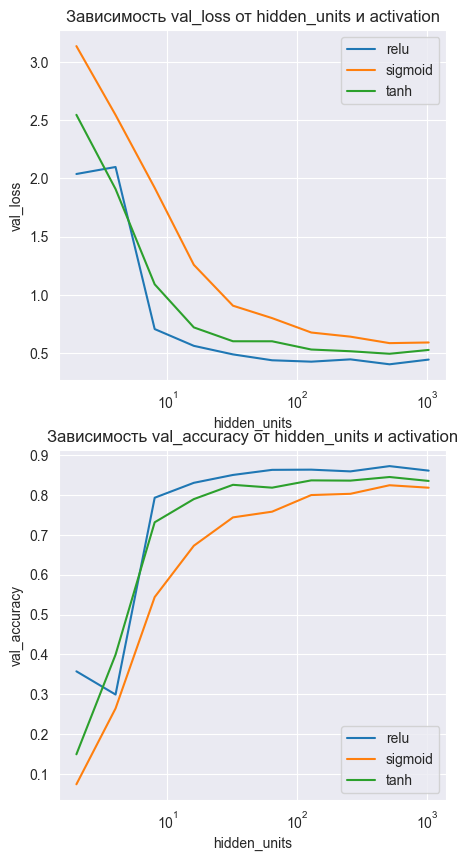

In [13]:
# Устанавливаем размер графика (10x10 дюймов)
plt.figure(figsize=(10, 10))

# Создаем два подграфика: один для val_loss, другой для val_accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))

activations = ['relu', 'sigmoid', 'tanh']
for idx, activation in enumerate(activations):
    val_losses = []
    val_accuracies = []
    for i in range(1, 11):
        model = configure_model(activation, 2**i)
        history = compile_model(model, 1)
        val_losses.append(history.history['val_loss'][-1])
        val_accuracies.append(history.history['val_accuracy'][-1])
    sns.lineplot(x = [2**i for i in range(1, 11)],y = val_losses, label=activation, ax=ax1)
    sns.lineplot(x=[2**i for i in range(1, 11)], y=val_accuracies, label=activation, ax=ax2)
    
ax1.set_xlabel('hidden_units')
ax1.set_ylabel('val_loss')
ax1.set_xscale('log')  # Логарифмический масштаб для оси X
ax1.set_title('Зависимость val_loss от hidden_units и activation')


ax2.set_xlabel('hidden_units')
ax2.set_ylabel('val_accuracy')
ax2.set_xscale('log')  # Логарифмический масштаб для оси X
ax2.set_title('Зависимость val_accuracy от hidden_units и activation')